In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import sys
sys.path.insert(0, '../..')

import quan_utils

In [2]:
import gpflow
import gpflowopt

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/quannguyen/anacond

In [3]:
prob_df = pd.read_csv('../../data/data.csv', index_col=0)
# capacity_df = prob_df['Real'].value_counts()


# All objective functions
def obj_f(x):
    real_alloc_constraint = x[:, 0]
    best_alloc_constraint = x[:, 1]
    
    helper = quan_utils.AssignmentHelper()
    
    helper.update_constraints(
        fairness_constraint=real_alloc_constraint,
        fairness_best_constraint=best_alloc_constraint
    )
    
    sol_df = helper.ip_solve()
    if sol_df is False:
        return np.hstack((
            # [[0]],
            [[1]],
            [[1]]
        ))
    
    # real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    return np.hstack((
        # [[- (real_n_reentries - sol_n_reentries) / real_n_reentries * 100]],
        [[prob_compare_df[prob_compare_df['Input_to_real'] > 0]['Input_to_real'].max()]],
        [[prob_compare_df[prob_compare_df['Input_to_best'] > 0]['Input_to_best'].max()]]
    ))

In [4]:
NUM_SAMPLES = 5

# Input domain
domain = gpflowopt.domain.ContinuousParameter('fairness constraint', 0.01, 0.2) \
         + gpflowopt.domain.ContinuousParameter('fairness best_constraint', 0, 1)
design = gpflowopt.design.LatinHyperCube(NUM_SAMPLES, domain)
X = design.generate()
X

array([[0.1525, 0.75  ],
       [0.105 , 0.    ],
       [0.01  , 0.5   ],
       [0.2   , 0.25  ],
       [0.0575, 1.    ]])

In [5]:
NUM_OBJS = 2

Y = np.array([obj_f(x.reshape(1, 2)) for x in X]).reshape(NUM_SAMPLES, NUM_OBJS)
Y

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


array([[0.1508268 , 0.5309186 ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.057494  , 0.55801695]])

In [6]:
# One model for each objective
objective_models = [gpflow.gpr.GPR(X.copy(), Y[:, [i]].copy(),
                                   gpflow.kernels.Matern52(2, ARD=True))
                    for i in range(Y.shape[1])]

for model in objective_models:
    model.likelihood.variance = 0.01
    
hvpoi = gpflowopt.acquisition.HVProbabilityOfImprovement(objective_models)

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/acquisition.py:193: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self.models[0].X.value, np.hstack(map(lambda model: model.Y.value, self.models))


In [7]:
BUDGET = 10

# Combine MC step followed by L-BFGS-B
acquisition_opt = gpflowopt.optim.StagedOptimizer([
    gpflowopt.optim.MCOptimizer(domain, 1000),
    gpflowopt.optim.SciPyOptimizer(domain)
])

# Run BO
optimizer = gpflowopt.BayesianOptimizer(
    domain, hvpoi, optimizer=acquisition_opt
)

result = optimizer.optimize(obj_f, n_iter=BUDGET)

Instructions for updating:
Colocations handled automatically by placer.


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/domain.py:97: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(map(lambda p: p.value, self._parameters)).T


Instructions for updating:
Use tf.cast instead.


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/hvpoi.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  F = np.hstack((m.predict_f(feasible_samples)[0] for m in self.models))


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/bo.py:150: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  evaluations = np.hstack(map(lambda f: f(X), fxs))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/acquisition.py:193: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self.models[0].X.value, np.hstack(map(lambda model: model.Y.value, self.models))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/hvpoi.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterabl

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/acquisition.py:193: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self.models[0].X.value, np.hstack(map(lambda model: model.Y.value, self.models))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/hvpoi.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  F = np.hstack((m.predict_f(feasible_samples)[0] for m in self.models))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/bo.py:150: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for

In [8]:
result

 constraints: array([], shape=(10, 0), dtype=float64)
         fun: array([[0.057494  , 0.55801695],
       [0.12367213, 0.53360549],
       [0.17662699, 0.52825288],
       [0.03318348, 0.57148758],
       [0.08828039, 0.54228367],
       [0.14237789, 0.5309186 ],
       [0.07287821, 0.54596009],
       [0.04638311, 0.56608073],
       [0.10268385, 0.5365947 ],
       [0.06485454, 0.55295661]])
     message: 'OK'
        nfev: 10
     success: True
           x: array([[0.0575    , 1.        ],
       [0.12413475, 0.94125316],
       [0.18019259, 0.78240967],
       [0.03318381, 0.91237977],
       [0.09007764, 0.89397569],
       [0.14365885, 0.78754674],
       [0.0728968 , 0.90555737],
       [0.04638488, 0.91095194],
       [0.1036711 , 0.88500538],
       [0.06485878, 0.90948632]])

In [9]:
hvpoi.data

(array([[0.1525    , 0.75      ],
        [0.105     , 0.        ],
        [0.01      , 0.5       ],
        [0.2       , 0.25      ],
        [0.0575    , 1.        ],
        [0.15290538, 0.86458615],
        [0.12413475, 0.94125316],
        [0.18019259, 0.78240967],
        [0.03318381, 0.91237977],
        [0.09007764, 0.89397569],
        [0.14365885, 0.78754674],
        [0.0728968 , 0.90555737],
        [0.04638488, 0.91095194],
        [0.1036711 , 0.88500538],
        [0.06485878, 0.90948632]]), array([[0.1508268 , 0.5309186 ],
        [1.        , 1.        ],
        [1.        , 1.        ],
        [1.        , 1.        ],
        [0.057494  , 0.55801695],
        [0.15283173, 0.5309186 ],
        [0.12367213, 0.53360549],
        [0.17662699, 0.52825288],
        [0.03318348, 0.57148758],
        [0.08828039, 0.54228367],
        [0.14237789, 0.5309186 ],
        [0.07287821, 0.54596009],
        [0.04638311, 0.56608073],
        [0.10268385, 0.5365947 ],
        [0.06

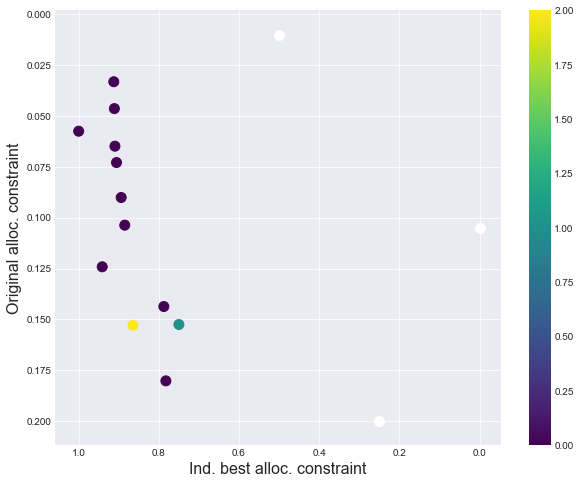

In [17]:
_, dom = gpflowopt.pareto.non_dominated_sort(hvpoi.data[1])

plt.figure(figsize=(10, 8))

plt.scatter(hvpoi.data[0][dom != 12, 1], hvpoi.data[0][dom != 12, 0],
            c=dom[dom!= 12], s=100, cmap='viridis')
plt.colorbar()
plt.scatter(hvpoi.data[0][dom == 12, 1], hvpoi.data[0][dom == 12, 0],
            c='white', s=100, cmap='viridis')

my_xlim = plt.xlim()
plt.xlim(my_xlim[1], my_xlim[0])
my_ylim = plt.ylim()
plt.ylim(my_ylim[1], my_ylim[0])

plt.xlabel('Ind. best alloc. constraint', fontsize=16)
plt.ylabel('Original alloc. constraint', fontsize=16)

plt.show()

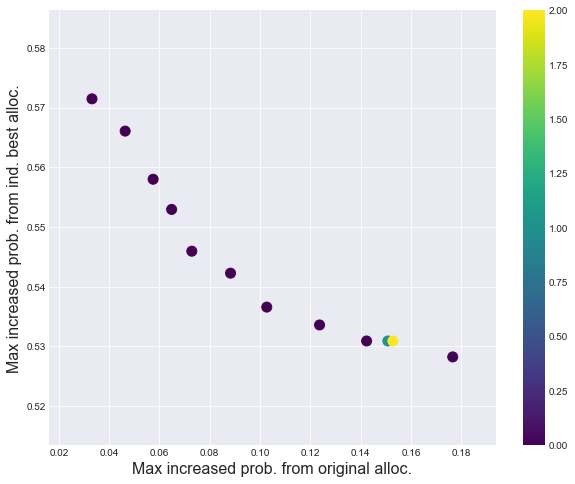

In [14]:
plt.figure(figsize=(10, 8))

plt.scatter(hvpoi.data[1][dom != 12, 0], hvpoi.data[1][dom != 12, 1], 
            c=dom[dom!= 12], s=100, cmap='viridis')
plt.colorbar()

plt.xlabel('Max increased prob. from original alloc.', fontsize=16)
plt.ylabel('Max increased prob. from ind. best alloc.', fontsize=16)

plt.show()

In [12]:
dom

array([ 1, 12, 12, 12,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0])